In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

trunc_normal= tf.truncated_normal_initializer(stddev=1)
normal = tf.random_normal_initializer(stddev=1)

from xgboost import XGBClassifier
from architectures.data_processing import *
from architectures.utils.toolbox import *
from architectures.DNN import *

In [3]:
l_index=1
l_flv=['e','mu']
mother_ID=["Ds","Dplus"]

# DATA LOADING & PREPROCESSING

In [4]:
with open('/disk/lhcb_data/davide/Rphipi/NN_for_selection/'+l_flv[l_index]+l_flv[l_index]+'/'+'data_for_NN_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'rb') as f:
    data_dict=pickle.load(f, encoding='latin1')
data_dict["Ds_ENDVERTEX_CHI2"]=data_dict["Ds_ENDVERTEX_CHI2"]/data_dict["Ds_ENDVERTEX_NDOF"]
data_dict["Ds_OWNPV_CHI2"]=data_dict["Ds_OWNPV_CHI2"]/data_dict["Ds_OWNPV_NDOF"]
data_dict["Ds_IPCHI2_OWNPV"]=data_dict["Ds_IPCHI2_OWNPV"]/data_dict["Ds_ENDVERTEX_NDOF"]

del data_dict["Ds_ENDVERTEX_NDOF"]
del data_dict["Ds_OWNPV_NDOF"]

data_dict["phi_ENDVERTEX_CHI2"]=data_dict["phi_ENDVERTEX_CHI2"]/data_dict["phi_ENDVERTEX_NDOF"]
#data_dict["phi_OWNPV_CHI2"]=data_dict["phi_OWNPV_CHI2"]/data_dict["phi_OWNPV_NDOF"]
data_dict["phi_IPCHI2_OWNPV"]=data_dict["phi_IPCHI2_OWNPV"]/data_dict["phi_ENDVERTEX_NDOF"]

del data_dict["phi_ENDVERTEX_NDOF"]
#del data_dict["phi_OWNPV_NDOF"]


In [5]:
task='TEST'

test=0
i=np.random.randint(6)
PATH=l_flv[l_index]+'/BDTs/test_'+str(test)+'/NN_'+str(i)

with open(PATH+'/variables_used.pkl', 'rb') as f:  
        branches_needed = pickle.load(f)
        
#Number of input features
m=data_dict["Ds_ConsD_M"].shape[0]
branches_needed.pop()
dim=len(branches_needed)

TypeError: 'protocol' is an invalid keyword argument for this function

In [15]:
data = extract_array(data_dict, branches_needed, dim, m)

data_mean=data.mean(axis=0)
data_1=data-data_mean
data_std=data_1.std(axis=0)
data_2=data_1/data_std
data_2.std(axis=0)
#data_2=data

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# NN SELECTION

In [16]:
with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
    hyper_dict = pickle.load(f)
    #for key, item in hyper_dict.items():
    #    print(key+':'+str(item))

k=hyper_dict["k"]
LEARNING_RATE=hyper_dict["LEARNING_RATE"]
BETA1=hyper_dict["BETA1"]
BATCH_SIZE=hyper_dict["BATCH_SIZE"]
EPOCHS=hyper_dict["EPOCHS"]
VAL_PERIOD=hyper_dict["VAL_PERIOD"]
SEED=hyper_dict["SEED"]
sizes=hyper_dict["sizes"]
LAMBD=hyper_dict["LAMBD"]
PATH=hyper_dict["PATH"]
    
if not os.path.exists(PATH+'/hyper_parameters.pkl'):
    print("No saved sizes dict")

In [17]:
tf.reset_default_graph()
model_NN = DNN(dim, sizes,
              lr=LEARNING_RATE, beta1=BETA1, lambd=LAMBD,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample=VAL_PERIOD, path=PATH, seed=SEED)

vars_to_train=tf.trainable_variables()
vars_all = tf.global_variables()
vars_to_init = list(set(vars_all)-set(vars_to_train))
init_op = tf.variables_initializer(vars_to_init)

saver = tf.train.Saver()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

Input for propagation (?, 13)
Logits shape (?, 2)
Input for propagation (?, 13)
Logits shape (?, 2)


In [19]:
output_dict_NN={}
batch_size=400
n_batches = data.shape[0]//batch_size

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init_op)
    print('\n Evaluate model on test set...')
    saver.restore(sess,PATH+'/NN_model.ckpt')
    print('Model restored.')
    model_NN.set_session(sess)
    for j in range(n_batches):
        
        small_dataset = data_2[j*batch_size:(j+1)*batch_size]
        output_dict_NN[j] = model_NN.predict(small_dataset)
        
    if data.shape[0]%batch_size != 0:
        output_dict_NN[j+1] = model_NN.predict(data_2[(j+1)*batch_size: data_2.shape[0]-1])
        
    output_NN=np.concatenate([output_dict_NN[i] for i in range(len(output_dict_NN))])


 Evaluate model on test set...
INFO:tensorflow:Restoring parameters from mu/test_0/NN_4/NN_model.ckpt
Model restored.


In [26]:
x_cut=0.5

In [37]:
a = data_dict["Ds_ConsD_M"][np.where(output_NN[:,1]>x_cut)[0]]
b = [data_dict["Ds_ConsD_M"][i] for i in range(len(data_dict["Ds_ConsD_M"]))]

NN_selected=np.array([a[i][0] for i in range(len(a))])
full = np.array([b[i][0] for i in range(len(b))])
full=np.delete(full,np.where(full<0))

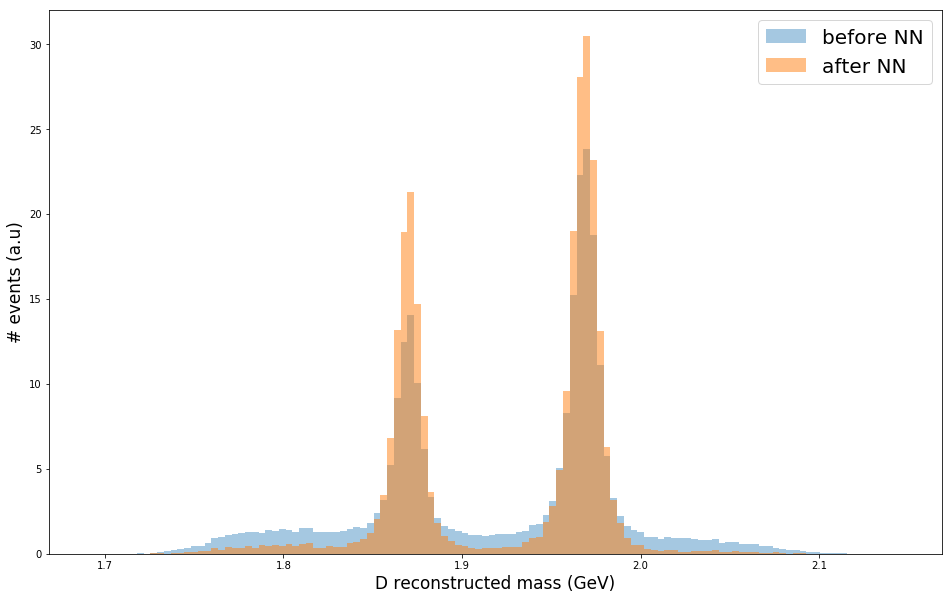

In [38]:
full_plot=full/1000
NN_selected_plot=NN_selected/1000
plt.hist(full_plot,alpha=0.4,bins=120, range=(full_plot.min(),full_plot.max()),density=True,label='before NN');
plt.hist(NN_selected_plot,alpha=0.5,bins=120, range=(full_plot.min(),full_plot.max()),density=True,label='after NN');
plt.legend(fontsize=20)

plt.xlabel('D reconstructed mass (GeV)', fontsize=17)
plt.ylabel('# events (a.u)', fontsize=17)

fig=plt.gcf();
fig.set_size_inches(16,10)
plt.savefig('/home/hep/davide/Rphipi/mu/test_'+str(test)+'/selected_data_NN.png', format='png', dpi=100)

In [39]:
np.save('/disk/lhcb_data/davide/Rphipi/selected_data/'+l_flv[l_index]+l_flv[l_index]+'/'+'sel_data_NN_'+l_flv[l_index]+l_flv[l_index]+'.npy', NN_selected)

# XGBOOST SELECTION

In [40]:
PATH=l_flv[l_index]+'/test_'+str(test)+'/XG_'+str(i)
loaded_model = pickle.load(open(PATH+"/XG_"+str(i)+"_.pickle.dat", "rb"))

In [41]:
output_XG=loaded_model.predict_proba(data_2)

In [42]:
a = data_dict["Ds_ConsD_M"][np.where(output_XG[:,1]>x_cut)[0]]
b = [data_dict["Ds_ConsD_M"][0:output_XG.shape[0]][i] for i in range(output_XG.shape[0])]

XG_selected=np.array([a[i][0] for i in range(len(a))])

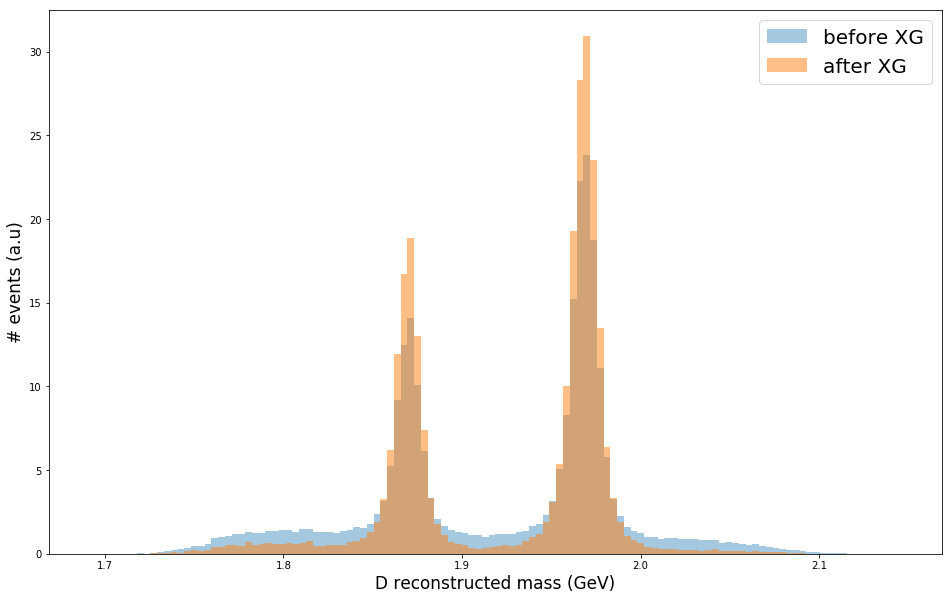

In [43]:

full_plot=full/1000
XG_selected_plot=XG_selected/1000

plt.hist(full_plot,alpha=0.4,bins=120, range=(full_plot.min(),full_plot.max()),density=True,label='before XG');
plt.hist(XG_selected_plot,alpha=0.5,bins=120, range=(full_plot.min(),full_plot.max()),density=True,label='after XG');
plt.legend(fontsize=20)
plt.xlabel('D reconstructed mass (GeV)', fontsize=17)
plt.ylabel('# events (a.u)', fontsize=17)
fig=plt.gcf();
fig.set_size_inches(16,10)
plt.savefig('/home/hep/davide/Rphipi/mu/test_'+str(test)+'/selected_data_XG.png', format='png', dpi=100)

In [44]:
np.save('/disk/lhcb_data/davide/Rphipi/selected_data/'+l_flv[l_index]+l_flv[l_index]+'/'+'sel_data_XG_'+l_flv[l_index]+l_flv[l_index]+'.npy', NN_selected)

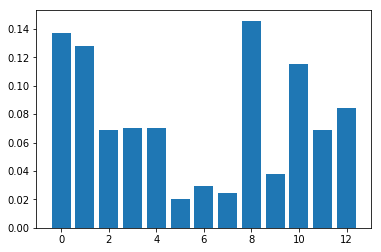

In [45]:
plt.bar(range(len(loaded_model.feature_importances_)), loaded_model.feature_importances_)
plt.show()